# NOS Sentiment analysis

In this notebook we will...

1. ...explore how the website of NOS.nl works "under the surface".
2. ...extract articles that match a particular search query on the website.
3. ...run a sentiment analysis on the data
4. ...visualize the results

In the default version of this notebook, we compare the news coverage of two prominent Dutch politicians: Sylvana Simons and Chris Segers. You are free of course, to run additional versions of the notebook with topics of your own choosing.

First we need to import some packages:

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import itertools
import matplotlib.pyplot as plt

## Exploring NOS.nl: the basics

To download articles on a specific topic we need to figure out two things:

1. We need to find the url that belongs to (leads to) a particular search result.
2. We need to find the urls of the articles in that search results.

### 1. url of search results

Point 1 is actually not that difficult. Just go to www.nos.nl and use the website's search function (the magnifying glass in the top right).

As you can see, searching for the term "Biden" brings us to the url https://nos.nl/zoeken?q=biden

Can you come up with the url that brings us to the search results for "Obama"? Enter that url in your browser and check what happens.
<details>
<summary>Answer</summary>
https://nos.nl/zoeken?q=obama
</details>
<br>

You can also search for multiple terms at once. Use the search function of the website to see what happens with the url when you do that.

If you want to search for a particular combinaton and order of words, you can use quotation marks. Bijv.: https://nos.nl/zoeken?q="verenigde+staten".

### 2. urls of articles

Now that we understand what url leads to what search results, we can let Python retreive the html code behind those search results (so that we can filter out the links to the pdf). 

To do so we need to first figure out what the html code looks like. Go to the page of one of the search results from above, and have a look at the html code (for instance with "inspect", or "view source"/ "page source" (depending on your own preference and/or browser)).

Can you find the class of the urls to the articles?

See if this helps you to understand the code below.



In [2]:
response = requests.get("https://nos.nl/zoeken?q=\"verenigde+staten\"")
html_string = response.text
soup = BeautifulSoup(html_string, "html.parser")

links = soup.find_all(class_='search-results__link', href=True)
for i in links:
    print(f"www.nos.nl{i['href']}")


www.nos.nl/artikel/2463788-noor-blijft-haken-in-starthuisje-wk-goud-voor-landenteam-verenigde-staten
www.nos.nl/artikel/2463445-zwemster-toussaint-vindt-in-spanje-nieuw-trainingsgeluk-word-er-flink-afgezwommen
www.nos.nl/artikel/2463819-geen-aanwijzing-voor-chinese-spionage-een-raket-miste-mysterieus-object
www.nos.nl/artikel/2463611-leger-vs-schiet-weer-onbekend-object-uit-de-lucht-mogelijk-spionage
www.nos.nl/artikel/2463552-vs-neergeschoten-objecten-bij-alaska-en-canada-waarschijnlijk-ballonnen
www.nos.nl/artikel/2463684-ooit-scoorde-hij-tegen-barcelona-nu-moet-hoesen-fc-emmen-in-eredivisie-houden
www.nos.nl/artikel/2463670-podcast-de-dag-geen-vogel-vliegtuig-of-alien-maar-een-chinese-ballon
www.nos.nl/artikel/2463075-zaalhockeysters-winnen-ook-laatste-groepsduel-mannen-veel-te-sterk-voor-belgie
www.nos.nl/artikel/2463131-washington-chinese-ballon-had-antennes-om-inlichtingen-te-verzamelen
www.nos.nl/artikel/2463033-biden-wil-dat-agenten-te-vertrouwen-zijn-maar-ryan-durft-niet-meer-

## Using other people's code to build our dataframe

Now that we have seen the basics, we will make use of some existing piece of code. We found it [here](https://github.com/nelewnsr/GGD-Sentimentsanalyse/blob/main/Web%20Scraping%20NOS.ipynb). There even is a really blog post, guiding you through the code, step by step: [here](https://www.breinstein.nl/de-digitale-wereld/use-case-web-scraping/), written by Nele Wensauer & Sanne Beurskens (big thanks!).

The code starts doing the same thing we already did: it collects the urls of the articles that we want to analyze. But it does a bit more than that:

1. It searches for articles from a particular starting date until now.
2. It cycles through the different pages of the search results, so that it does not just collect the urls of the first page of the search results, the all the urls on all the pages of the search results.
3. It does not just collect the urls of the articles, it also collects the title of the articles, the date of the articles and the text of the articles, and it saves this data in a dataframe (that we can use for the sentiment analysis).


In [3]:
# Verzamel URL van elk artikel
pagelinks = []  # aanmaken leeg object om met links te vullen
urlbase = "https://nos.nl/zoeken?q=\"Sylvana+Simons\"&date=2012-01-01&page=1"  # basis URL 
url = urlbase

while True:  # run loop terwijl IF statement TRUE is
    page = requests.get(url)  # benader URL
    soup = BeautifulSoup(page.content, 'html.parser')  # download HTML-code
    weblinks = soup.find_all("a", {"class": "search-results__link"})  # verzamel alle HTML-code van de artikelen
    pl =[]
    for i in range(len(weblinks)):   # voor elke HTML-code die een artikellink bevat: 
            pl.append('http://nos.nl'+ weblinks[i].get('href'))   # sla alle links uit de HTML-code op
    pagelinks.append(pl)  # voeg deze toe aan het object pagelinks
    if soup.find_all("span", {"class": "js-update link-hover"}):  # run loop terwijl dit TRUE is
        next_page = soup.find("span", {"class": "js-update link-hover"})  # verzamel de HTML-code van de volgende pagina
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"  # haal de url eruit en voeg samen tot een link
    else:
        break

pagelinks_flat = list(itertools.chain(*pagelinks))  # flatten de list

# print the last five results
print(len(pagelinks_flat))
pagelinks_flat[:5]

214


['http://nos.nl/artikel/2453741-toch-inspectie-onderzoek-naar-politieoptreden-bij-zwartepietbetoging-staphorst',
 'http://nos.nl/artikel/2453437-yesilgoz-botst-fel-met-simons-over-nasleep-sint-intocht-staphorst',
 'http://nos.nl/artikel/2449360-stemmodule-ns-publieksprijs-tijdelijk-stilgelegd-na-meldingen-van-fraude',
 'http://nos.nl/artikel/2446375-onderzoek-bonaire-dreigt-onder-te-lopen-bij-extreme-klimaatverandering',
 'http://nos.nl/collectie/13892/artikel/2420452-veldbedden-en-gastgezinnen-moeten-helpen-bij-noodopvang-oekrainers']

In [4]:
# Verzamel URL van elk artikel
pagelinks = []  # aanmaken leeg object om met links te vullen
urlbase = "https://nos.nl/zoeken?q=\"Sylvana+Simons\"&date=2012-01-01&page=1"  # basis URL 
url = urlbase

while True:  # run loop terwijl IF statement TRUE is
    page = requests.get(url)  # benader URL
    soup = BeautifulSoup(page.content, 'html.parser')  # download HTML-code
    weblinks = soup.find_all("a", {"class": "search-results__link"})  # verzamel alle HTML-code van de artikelen
    pl =[]
    for i in range(len(weblinks)):   # voor elke HTML-code die een artikellink bevat: 
            pl.append('http://nos.nl'+ weblinks[i].get('href'))   # sla alle links uit de HTML-code op
    pagelinks.append(pl)  # voeg deze toe aan het object pagelinks
    if soup.find_all("span", {"class": "js-update link-hover"}):  # run loop terwijl dit TRUE is
        next_page = soup.find("span", {"class": "js-update link-hover"})  # verzamel de HTML-code van de volgende pagina
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"  # haal de url eruit en voeg samen tot een link
    else:
        break

pagelinks_flat = list(itertools.chain(*pagelinks))  # flatten de list

# print the last five results
print(len(pagelinks_flat))
pagelinks_flat[:5]

214


['http://nos.nl/artikel/2453741-toch-inspectie-onderzoek-naar-politieoptreden-bij-zwartepietbetoging-staphorst',
 'http://nos.nl/artikel/2453437-yesilgoz-botst-fel-met-simons-over-nasleep-sint-intocht-staphorst',
 'http://nos.nl/artikel/2449360-stemmodule-ns-publieksprijs-tijdelijk-stilgelegd-na-meldingen-van-fraude',
 'http://nos.nl/artikel/2446375-onderzoek-bonaire-dreigt-onder-te-lopen-bij-extreme-klimaatverandering',
 'http://nos.nl/artikel/2444459-simons-over-ruzie-bij1-wij-zijn-niet-verheven-boven-conflicten-in-de-samenleving']

In [5]:
# Verzamel titel van elk artikel
title = []
url = urlbase

while True:
    page = requests.get(url) 
    soup = BeautifulSoup(page.content, 'html.parser')
    titles = soup.find_all("h3", {"class": "search-results__title"})  # aangepast naar titel node en class
    tt = []
    for i in range(len(titles)):    
          tt.append(titles[i].get_text())
    title.append(tt)
    if soup.find_all("span", {"class": "js-update link-hover"}):
        next_page = soup.find("span", {"class": "js-update link-hover"})
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"
    else:
        break
        
title_flat = list(itertools.chain(*title))
title_flat[:5]

['Toch Inspectie-onderzoek naar politieoptreden bij zwartepietbetoging Staphorst',
 'Yesilgöz botst fel met Simons over nasleep Sint-intocht Staphorst',
 'Stemmodule NS Publieksprijs tijdelijk stilgelegd na meldingen van fraude',
 'Onderzoek: Bonaire dreigt onder te lopen bij extreme klimaatverandering',
 'Veldbedden en gastgezinnen moeten helpen bij noodopvang Oekraïners ']

In [6]:
# Verzamel datum van elk artikel
date = []
url = urlbase

while True:
    page = requests.get(url) 
    soup = BeautifulSoup(page.content, 'html.parser')
    time = soup.find_all("time", {"class": "search-results__time"})  # aangepast naar datum node en class
    dt = []
    for i in range(len(time)):    
          dt.append(time[i].get('datetime'))
    date.append(dt)
    if soup.find_all("span", {"class": "js-update link-hover"}):
        next_page = soup.find("span", {"class": "js-update link-hover"})
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"
    else:
        break
        
date_flat = list(itertools.chain(*date))
date_flat[:5]

['2022-11-24T17:01:31+0100',
 '2022-11-22T15:53:39+0100',
 '2022-10-22T15:30:52+0200',
 '2022-09-28T20:46:40+0200',
 '2022-03-09T13:32:40+0100']

In [7]:
# Verzamel de tekst van elk artikel
thearticle = []
iter=0
for link in pagelinks_flat:    
    paragraphtext = []    
    url = link
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')    
    if "video" in link:
        articletext = soup.find_all('p', {"class": 'videoDescription_bAtNIfDM'})
    else:
        #articletext = soup.find_all('p', {"class":'text_3v_J6Y0G'})
        articletext = soup.find_all('p', {'data-testid': 'text'})
    for paragraph in articletext:
        text = paragraph.get_text()
        paragraphtext.append(text)        
    thearticle.append(paragraphtext)
    iter=iter+1
    if iter % 10 == 0:
        print(f"{iter} out of {len(pagelinks_flat)}")
    
thearticle[0]

10 out of 214
20 out of 214
30 out of 214
40 out of 214
50 out of 214
60 out of 214
70 out of 214
80 out of 214
90 out of 214
100 out of 214
110 out of 214
120 out of 214
130 out of 214
140 out of 214
150 out of 214
160 out of 214
170 out of 214
180 out of 214
190 out of 214
200 out of 214
210 out of 214


['De Inspectie Justitie en Veiligheid gaat het optreden van de politie van afgelopen zaterdag in Staphorst onderzoeken. De actiegroep Kick Out Zwarte Piet (KOZP) wilde daar demonstreren omdat er zwarte pieten meeliepen bij de intocht van Sinterklaas, maar de betogers werden voordat ze het plein in het dorp konden bereiken, belaagd door relschoppers.',
 'Er kwam naderhand veel kritiek op het optreden van de politie. De politie zou onvoldoende hebben gedaan om de demonstranten te beschermen.',
 "De demonstranten van KOZP en Amnesty-waarnemers werden op de afrit van de A28 tegengehouden door tientallen mensen. Hun auto's werden bekogeld met eieren en banden werden lekgeprikt. De politie greep niet in, terwijl het juist de bedoeling was dat agenten de demonstranten naar het centrum van het dorp zouden begeleiden.",
 'In een verklaring van de Inspectie staat dat de politie wordt verweten al jaren niet neutraal te handelen bij demonstraties. Dat verwijt en de vraag vanuit de Tweede Kamer naa

In [8]:
# Lists samenvoegen in dataframe
df = pd.DataFrame(
    {'datetime': date_flat,
     'pagelink': pagelinks_flat,
     'title': title_flat,
     'text': thearticle
    })

df.head(2)

datetime  \
0  2022-11-24T17:01:31+0100   
1  2022-11-22T15:53:39+0100   

                                            pagelink  \
0  http://nos.nl/artikel/2453741-toch-inspectie-o...   
1  http://nos.nl/artikel/2453437-yesilgoz-botst-f...   

                                               title  \
0  Toch Inspectie-onderzoek naar politieoptreden ...   
1  Yesilgöz botst fel met Simons over nasleep Sin...   

                                                text  
0  [De Inspectie Justitie en Veiligheid gaat het ...  
1  [Minister Yesilgöz vindt achteraf dat ze bij d...

In [9]:
# Liveblogs eruit filteren
df = df[df["pagelink"].str.contains("liveblog")==False].reset_index(drop=True)

In [10]:
# Leestekens verwijderen, hoofdletters vervangen door kleine letters en titel en tekst samenvoegen
df['pure_title'] = df['title'].str.replace('[^A-Za-z0-9 ]+', ' ').str.lower()
df['pure_text'] = df['text'].astype(str).str.replace('[^A-Za-z0-9 ]+', ' ').str.lower()
df['title_text'] = df['pure_title'] + df['pure_text']
df.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


datetime  \
0  2022-11-24T17:01:31+0100   
1  2022-11-22T15:53:39+0100   
2  2022-10-22T15:30:52+0200   
3  2022-09-28T20:46:40+0200   
4  2022-03-09T13:32:40+0100   

                                            pagelink  \
0  http://nos.nl/artikel/2453741-toch-inspectie-o...   
1  http://nos.nl/artikel/2453437-yesilgoz-botst-f...   
2  http://nos.nl/artikel/2449360-stemmodule-ns-pu...   
3  http://nos.nl/artikel/2446375-onderzoek-bonair...   
4  http://nos.nl/artikel/2444459-simons-over-ruzi...   

                                               title  \
0  Toch Inspectie-onderzoek naar politieoptreden ...   
1  Yesilgöz botst fel met Simons over nasleep Sin...   
2  Stemmodule NS Publieksprijs tijdelijk stilgele...   
3  Onderzoek: Bonaire dreigt onder te lopen bij e...   
4  Veldbedden en gastgezinnen moeten helpen bij n...   

                                                text  \
0  [De Inspectie Justitie en Veiligheid gaat het ...   
1  [Minister Yesilgöz vindt achteraf dat ze bij d...   
2  [De stemmodule voor de NS Publieksprijs is eni...   
3  [Door de zeespiegelstijging dreigt een vijfde ...   
4  ["Er is onvrede binnen de partij, dat kan ik n...   

                                          pure_title  \
0  toch inspectie onderzoek naar politieoptreden ...   
1  yesilg z botst fel met simons over nasleep sin...   
2  stemmodule ns publieksprijs tijdelijk stilgele...   
3  onderzoek  bonaire dreigt onder te lopen bij e...   
4  veldbedden en gastgezinnen moeten helpen bij n...   

                                           pure_text  \
0   de inspectie justitie en veiligheid gaat het ...   
1   minister yesilg z vindt achteraf dat ze bij d...   
2   de stemmodule voor de ns publieksprijs is eni...   
3   door de zeespiegelstijging dreigt een vijfde ...   
4   er is onvrede binnen de partij  dat kan ik ni...   

                                          title_text  
0  toch inspectie onderzoek naar politieoptreden ...  
1  yesilg z botst fel met simons over nasleep sin...  
2  stemmodule ns publieksprijs tijdelijk stilgele...  
3  onderzoek  bonaire dreigt onder te lopen bij e...  
4  veldbedden en gastgezinnen moeten helpen bij n...

At this point we have a dataframe with all the articles from the search result for the query "Sylvana Simons" from 1 January 2012 onwards. Let's explore this data.


# Sentimentanalyse

In this part of the notebook, we will run the sentiment analysis. In it's most basic form, a sentiment analysis basically just counts the number of words that are generally believed to be negative, and words that are generally believed to be positive. Have a look at the text files for negative and positive words in the folder ../../data/processed/. Do you agree that they are negative/positive?

It is important to realize that an article about a politician with a lot negative words is not necessarily an article that is negative about that politician. It could just as well be an article that condemns people for inappropriately criticizing that politician. It is always important to remain critical of the output of our code!

In [11]:
# Inladen van dataset met positieve en negatieve woorden
# (Chen, Y., & Skiena, S., 2014. Building Sentiment Lexicons for All Major Languages. In ACL (2) (pp. 383-389))
negative = pd.read_csv('../../data/processed/negative_words_nl.txt', header=None).rename(columns={0: 'word'})
negative['negative'] = 1
positive = pd.read_csv('../../data/processed/positive_words_nl.txt', header=None).rename(columns={0: 'word'})
positive['positive'] = 1

In [12]:
# Woorden uit txt bestand samenvoegen in een dataframe 
words = positive.append(negative).fillna(0)
words

word  positive  negative
0          eerste       1.0       0.0
1            naam       1.0       0.0
2            waar       1.0       0.0
3             wel       1.0       0.0
4           zoals       1.0       0.0
...           ...       ...       ...
2465   stereotiep       0.0       1.0
2466    smeekbede       0.0       1.0
2467  irrationaal       0.0       1.0
2468       gallen       0.0       1.0
2469  erbarmelijk       0.0       1.0

[3969 rows x 3 columns]

In [13]:
# Tekst opsplitsen in woorden
df_sentiment = df[['title_text']]
df_sent = df_sentiment['title_text'].str.split(' ', expand=True).stack().reset_index(level=0)
df_sent = df_sent.rename(columns={0: 'word'})
df_sent.head()

level_0             word
0        0             toch
1        0        inspectie
2        0        onderzoek
3        0             naar
4        0  politieoptreden

In [14]:
# df_sent inner joinen met words en groeperen per artikel
join = df_sent.merge(words, how='inner', on='word')
join_sum = join.groupby('level_0')[["positive", "negative"]].sum()
join_sum.head()

positive  negative
level_0                    
0            13.0      27.0
1            13.0      25.0
2            10.0       8.0
3            18.0      20.0
4            14.0      36.0

In [15]:
join_sum.describe()

positive    negative
count  185.000000  185.000000
mean    14.897297   21.735135
std     13.343914   16.038680
min      0.000000    0.000000
25%      6.000000   10.000000
50%     12.000000   19.000000
75%     20.000000   28.000000
max     74.000000   77.000000

In [16]:
# Alles samenvoegen in data
data = df.merge(join_sum, left_index=True, right_index=True, how='left')
data = data.drop(columns=['title', 'text', 'pure_title', 'pure_text'])
data.head()

datetime  \
0  2022-11-24T17:01:31+0100   
1  2022-11-22T15:53:39+0100   
2  2022-10-22T15:30:52+0200   
3  2022-09-28T20:46:40+0200   
4  2022-03-09T13:32:40+0100   

                                            pagelink  \
0  http://nos.nl/artikel/2453741-toch-inspectie-o...   
1  http://nos.nl/artikel/2453437-yesilgoz-botst-f...   
2  http://nos.nl/artikel/2449360-stemmodule-ns-pu...   
3  http://nos.nl/artikel/2446375-onderzoek-bonair...   
4  http://nos.nl/artikel/2444459-simons-over-ruzi...   

                                          title_text  positive  negative  
0  toch inspectie onderzoek naar politieoptreden ...      13.0      27.0  
1  yesilg z botst fel met simons over nasleep sin...      13.0      25.0  
2  stemmodule ns publieksprijs tijdelijk stilgele...      10.0       8.0  
3  onderzoek  bonaire dreigt onder te lopen bij e...      18.0      20.0  
4  veldbedden en gastgezinnen moeten helpen bij n...      14.0      36.0

In [17]:
# Verschil berekenen
data['verschil'] = data['positive'] - data['negative']
data['verschil'].mean

In [18]:
# Splitsing joinen met data
df3 = df[['datetime']]
data = data.merge(df3, on = 'datetime', how='left')
data.head(3)

datetime  \
0  2022-11-24T17:01:31+0100   
1  2022-11-22T15:53:39+0100   
2  2022-10-22T15:30:52+0200   

                                            pagelink  \
0  http://nos.nl/artikel/2453741-toch-inspectie-o...   
1  http://nos.nl/artikel/2453437-yesilgoz-botst-f...   
2  http://nos.nl/artikel/2449360-stemmodule-ns-pu...   

                                          title_text  positive  negative  \
0  toch inspectie onderzoek naar politieoptreden ...      13.0      27.0   
1  yesilg z botst fel met simons over nasleep sin...      13.0      25.0   
2  stemmodule ns publieksprijs tijdelijk stilgele...      10.0       8.0   

   verschil  
0     -14.0  
1     -12.0  
2       2.0

In [19]:
# Datetime gebruiken zodat het als een datum wordt gezien
data['datetime'] = data['datetime'].str.slice(0, -14)
data['datetime'] = pd.to_datetime(data['datetime'])
data.head(3)

datetime                                           pagelink  \
0 2022-11-24  http://nos.nl/artikel/2453741-toch-inspectie-o...   
1 2022-11-22  http://nos.nl/artikel/2453437-yesilgoz-botst-f...   
2 2022-10-22  http://nos.nl/artikel/2449360-stemmodule-ns-pu...   

                                          title_text  positive  negative  \
0  toch inspectie onderzoek naar politieoptreden ...      13.0      27.0   
1  yesilg z botst fel met simons over nasleep sin...      13.0      25.0   
2  stemmodule ns publieksprijs tijdelijk stilgele...      10.0       8.0   

   verschil  
0     -14.0  
1     -12.0  
2       2.0

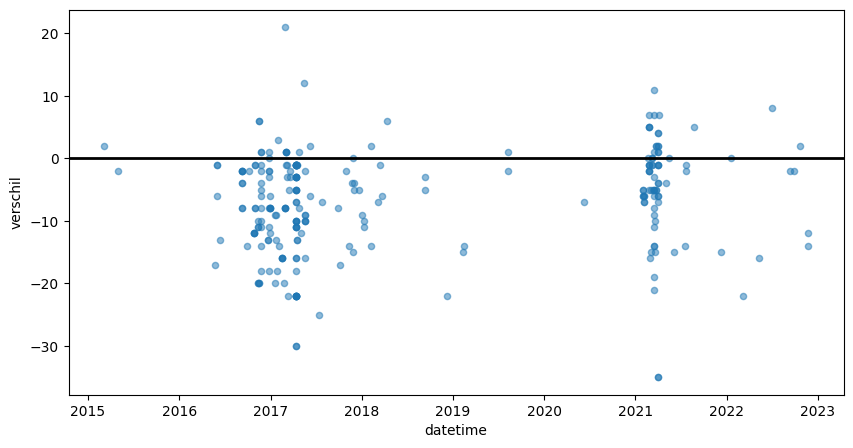

In [20]:
# Plot verschil positief negatief
plt.rcParams["figure.figsize"] = (10, 5)
data.plot.scatter(x="datetime", y="verschil", alpha=0.5)
plt.axhline(y=0, linewidth=2, color='black')

In [21]:
# Gemiddelde per maand
data_mean = data.groupby(pd.Grouper(key='datetime',freq='M')).mean().reset_index()
# Aantal artikelen per maand
data_count = data.groupby(pd.Grouper(key='datetime',freq='M')).count().reset_index()
data_count = data_count[['datetime', 'pagelink']].rename(columns={'pagelink': 'number_of_articles'})
# Samenvoegen
data_mean_count = data_mean.merge(data_count, on = 'datetime', how='left')
data_mean_count.head(3)

datetime  positive  negative  verschil  number_of_articles
0 2015-03-31      11.0       9.0       2.0                   1
1 2015-04-30       NaN       NaN       NaN                   0
2 2015-05-31       4.0       6.0      -2.0                   1

<AxesSubplot:xlabel='datetime', ylabel='number_of_articles'>

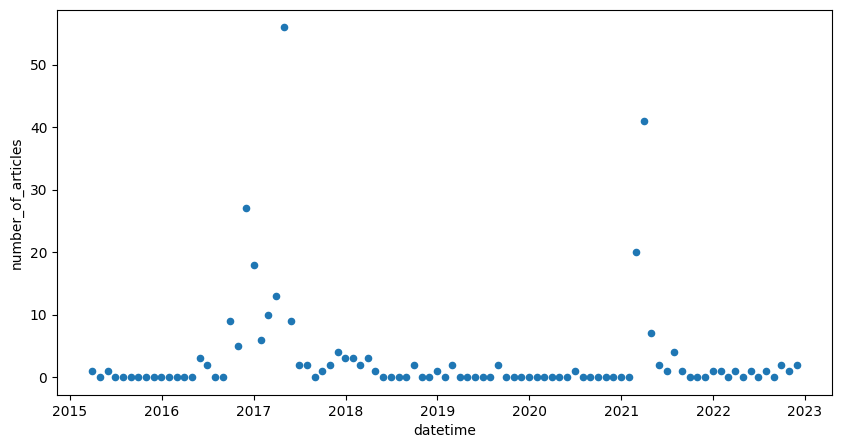

In [22]:
# Plot aantal artikelen per maand
plt.rcParams["figure.figsize"] = (10, 5)
data_mean_count.plot.scatter(x="datetime", y='number_of_articles')

# Let's try with another politician

In [78]:
# Verzamel URL van elk artikel
pagelinks = []  # aanmaken leeg object om met links te vullen
urlbase = "https://nos.nl/zoeken?q=\"Gert-Jan+Segers\"&date=2012-01-01&page=1"  # basis URL 
url = urlbase

while True:  # run loop terwijl IF statement TRUE is
    page = requests.get(url)  # benader URL
    soup = BeautifulSoup(page.content, 'html.parser')  # download HTML-code
    weblinks = soup.find_all("a", {"class": "search-results__link"})  # verzamel alle HTML-code van de artikelen
    pl =[]
    for i in range(len(weblinks)):   # voor elke HTML-code die een artikellink bevat: 
            pl.append('http://nos.nl'+ weblinks[i].get('href'))   # sla alle links uit de HTML-code op
    pagelinks.append(pl)  # voeg deze toe aan het object pagelinks
    if soup.find_all("span", {"class": "js-update link-hover"}):  # run loop terwijl dit TRUE is
        next_page = soup.find("span", {"class": "js-update link-hover"})  # verzamel de HTML-code van de volgende pagina
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"  # haal de url eruit en voeg samen tot een link
    else:
        break

pagelinks_flat = list(itertools.chain(*pagelinks))  # flatten de list

# print the last five results
print(len(pagelinks_flat))
pagelinks_flat[:5]

379


['http://nos.nl/video/2461067-groot-applaus-en-een-lintje-voor-gert-jan-segers',
 'http://nos.nl/artikel/2461062-segers-christenunie-bij-afscheid-van-kamer-democratie-op-kruispunt',
 'http://nos.nl/artikel/2461001-wekdienst-24-1-segers-neemt-afscheid-van-tweede-kamer-stadsreiniging-almere-legt-werk-neer',
 'http://nos.nl/nieuwsuur/video/2459747-christenunie-leider-gert-jan-segers-verlaat-de-politiek',
 'http://nos.nl/video/2459661-gert-jan-segers-het-zit-erop']

In [79]:
# Verzamel titel van elk artikel
title = []
url = urlbase

while True:
    page = requests.get(url) 
    soup = BeautifulSoup(page.content, 'html.parser')
    titles = soup.find_all("h3", {"class": "search-results__title"})  # aangepast naar titel node en class
    tt = []
    for i in range(len(titles)):    
          tt.append(titles[i].get_text())
    title.append(tt)
    if soup.find_all("span", {"class": "js-update link-hover"}):
        next_page = soup.find("span", {"class": "js-update link-hover"})
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"
    else:
        break
        
title_flat = list(itertools.chain(*title))
title_flat[:5]

['Groot applaus en een lintje voor Gert-Jan Segers',
 "Segers (ChristenUnie) bij afscheid van Kamer: 'Democratie op kruispunt'",
 'Wekdienst 24/1: Segers neemt afscheid van Tweede Kamer • Stadsreiniging Almere legt werk neer ',
 'ChristenUnie-leider Gert-Jan Segers verlaat de politiek',
 "Gert-Jan Segers: 'Het zit erop'"]

In [80]:
# Verzamel datum van elk artikel
date = []
url = urlbase

while True:
    page = requests.get(url) 
    soup = BeautifulSoup(page.content, 'html.parser')
    time = soup.find_all("time", {"class": "search-results__time"})  # aangepast naar datum node en class
    dt = []
    for i in range(len(time)):    
          dt.append(time[i].get('datetime'))
    date.append(dt)
    if soup.find_all("span", {"class": "js-update link-hover"}):
        next_page = soup.find("span", {"class": "js-update link-hover"})
        url = "https://nos.nl" + next_page.get('data-url') + "&date=2012-01-01"
    else:
        break
        
date_flat = list(itertools.chain(*date))
date_flat[:5]

['2023-01-24T16:30:30+0100',
 '2023-01-24T15:57:57+0100',
 '2023-01-24T06:57:26+0100',
 '2023-01-13T22:03:11+0100',
 '2023-01-13T10:19:08+0100']

In [81]:
# Verzamel de tekst van elk artikel
thearticle = []
iter=0
for link in pagelinks_flat:    
    paragraphtext = []    
    url = link
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')    
    if "video" in link:
        articletext = soup.find_all('p', {"class": 'videoDescription_bAtNIfDM'})
    else:
        # articletext = soup.find_all('p', {"class":'text_3v_J6Y0G'})
        articletext = soup.find_all('p', {'data-testid': 'text'})
    for paragraph in articletext:
        text = paragraph.get_text()
        paragraphtext.append(text)        
    thearticle.append(paragraphtext)
    iter=iter+1
    if iter % 10 == 0:
        print(f"{iter} out of {len(pagelinks_flat)}")
    
thearticle[0]

10 out of 379
20 out of 379
30 out of 379
40 out of 379
50 out of 379
60 out of 379
70 out of 379
80 out of 379
90 out of 379
100 out of 379
110 out of 379
120 out of 379
130 out of 379
140 out of 379
150 out of 379
160 out of 379
170 out of 379
180 out of 379
190 out of 379
200 out of 379
210 out of 379
220 out of 379
230 out of 379
240 out of 379
250 out of 379
260 out of 379
270 out of 379
280 out of 379
290 out of 379
300 out of 379
310 out of 379
320 out of 379
330 out of 379
340 out of 379
350 out of 379
360 out of 379
370 out of 379


[]

In [82]:
# Lists samenvoegen in dataframe
df = pd.DataFrame(
    {'datetime': date_flat,
     'pagelink': pagelinks_flat,
     'title': title_flat,
     'text': thearticle
    })

df.head(2)

datetime  \
0  2023-01-24T16:30:30+0100   
1  2023-01-24T15:57:57+0100   

                                            pagelink  \
0  http://nos.nl/video/2461067-groot-applaus-en-e...   
1  http://nos.nl/artikel/2461062-segers-christenu...   

                                               title  \
0   Groot applaus en een lintje voor Gert-Jan Segers   
1  Segers (ChristenUnie) bij afscheid van Kamer: ...   

                                                text  
0                                                 []  
1  ["De democratie staat op een kruispunt." Dat z...

In [83]:
# Liveblogs eruit filteren
df = df[df["pagelink"].str.contains("liveblog")==False].reset_index(drop=True)

In [84]:
# Leestekens verwijderen, hoofdletters vervangen door kleine letters en titel en tekst samenvoegen
df['pure_title'] = df['title'].str.replace('[^A-Za-z0-9 ]+', ' ').str.lower()
df['pure_text'] = df['text'].astype(str).str.replace('[^A-Za-z0-9 ]+', ' ').str.lower()
df['title_text'] = df['pure_title'] + df['pure_text']
df.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


datetime  \
0  2023-01-24T16:30:30+0100   
1  2023-01-24T15:57:57+0100   
2  2023-01-24T06:57:26+0100   
3  2023-01-13T22:03:11+0100   
4  2023-01-13T10:19:08+0100   

                                            pagelink  \
0  http://nos.nl/video/2461067-groot-applaus-en-e...   
1  http://nos.nl/artikel/2461062-segers-christenu...   
2  http://nos.nl/artikel/2461001-wekdienst-24-1-s...   
3  http://nos.nl/nieuwsuur/video/2459747-christen...   
4  http://nos.nl/video/2459661-gert-jan-segers-he...   

                                               title  \
0   Groot applaus en een lintje voor Gert-Jan Segers   
1  Segers (ChristenUnie) bij afscheid van Kamer: ...   
2  Wekdienst 24/1: Segers neemt afscheid van Twee...   
3  ChristenUnie-leider Gert-Jan Segers verlaat de...   
4                    Gert-Jan Segers: 'Het zit erop'   

                                                text  \
0                                                 []   
1  ["De democratie staat op een kruispunt." Dat z...   
2  [Goedemorgen! Vandaag neemt oud-fractievoorzit...   
3                                                 []   
4                                                 []   

                                          pure_title  \
0   groot applaus en een lintje voor gert jan segers   
1  segers  christenunie  bij afscheid van kamer  ...   
2  wekdienst 24 1  segers neemt afscheid van twee...   
3  christenunie leider gert jan segers verlaat de...   
4                    gert jan segers   het zit erop    

                                           pure_text  \
0                                                      
1   de democratie staat op een kruispunt  dat zei...   
2   goedemorgen  vandaag neemt oud fractievoorzit...   
3                                                      
4                                                      

                                          title_text  
0  groot applaus en een lintje voor gert jan segers   
1  segers  christenunie  bij afscheid van kamer  ...  
2  wekdienst 24 1  segers neemt afscheid van twee...  
3  christenunie leider gert jan segers verlaat de...  
4                   gert jan segers   het zit erop

# Sentimentanalyse

In [85]:
# Inladen van dataset met positieve en negatieve woorden
# (Chen, Y., & Skiena, S., 2014. Building Sentiment Lexicons for All Major Languages. In ACL (2) (pp. 383-389))
negative = pd.read_csv('../../data/processed/negative_words_nl.txt', header=None).rename(columns={0: 'word'})
negative['negative'] = 1
positive = pd.read_csv('../../data/processed/positive_words_nl.txt', header=None).rename(columns={0: 'word'})
positive['positive'] = 1

In [86]:
# Woorden uit txt bestand samenvoegen in een dataframe 
words = positive.append(negative).fillna(0)
words

word  positive  negative
0          eerste       1.0       0.0
1            naam       1.0       0.0
2            waar       1.0       0.0
3             wel       1.0       0.0
4           zoals       1.0       0.0
...           ...       ...       ...
2465   stereotiep       0.0       1.0
2466    smeekbede       0.0       1.0
2467  irrationaal       0.0       1.0
2468       gallen       0.0       1.0
2469  erbarmelijk       0.0       1.0

[3969 rows x 3 columns]

In [87]:
# Tekst opsplitsen in woorden
df_sentiment = df[['title_text']]
df_sent = df_sentiment['title_text'].str.split(' ', expand=True).stack().reset_index(level=0)
df_sent = df_sent.rename(columns={0: 'word'})
df_sent.head()

level_0     word
0        0    groot
1        0  applaus
2        0       en
3        0      een
4        0   lintje

In [88]:
# df_sent inner joinen met words en groeperen per artikel
join = df_sent.merge(words, how='inner', on='word')
join_sum = join.groupby('level_0')[["positive", "negative"]].sum()
join_sum.head()

positive  negative
level_0                    
0             1.0       0.0
1            17.0      13.0
2             9.0       8.0
3             0.0       1.0
5            12.0       6.0

In [89]:
join_sum.describe()

positive    negative
count  312.000000  312.000000
mean    18.262821   20.711538
std     16.191623   18.092122
min      0.000000    0.000000
25%      7.750000   10.000000
50%     14.000000   17.000000
75%     25.250000   27.000000
max    123.000000  127.000000

In [90]:
# Alles samenvoegen in data
data = df.merge(join_sum, left_index=True, right_index=True, how='left')
data = data.drop(columns=['title', 'text', 'pure_title', 'pure_text'])
data.head()

datetime  \
0  2023-01-24T16:30:30+0100   
1  2023-01-24T15:57:57+0100   
2  2023-01-24T06:57:26+0100   
3  2023-01-13T22:03:11+0100   
4  2023-01-13T10:19:08+0100   

                                            pagelink  \
0  http://nos.nl/video/2461067-groot-applaus-en-e...   
1  http://nos.nl/artikel/2461062-segers-christenu...   
2  http://nos.nl/artikel/2461001-wekdienst-24-1-s...   
3  http://nos.nl/nieuwsuur/video/2459747-christen...   
4  http://nos.nl/video/2459661-gert-jan-segers-he...   

                                          title_text  positive  negative  
0  groot applaus en een lintje voor gert jan segers        1.0       0.0  
1  segers  christenunie  bij afscheid van kamer  ...      17.0      13.0  
2  wekdienst 24 1  segers neemt afscheid van twee...       9.0       8.0  
3  christenunie leider gert jan segers verlaat de...       0.0       1.0  
4                   gert jan segers   het zit erop         NaN       NaN

In [91]:
# Verschil berekenen
data['verschil'] = data['positive'] - data['negative']
data['verschil'].mean()

In [92]:
# Splitsing joinen met data
df3 = df[['datetime']]
data = data.merge(df3, on = 'datetime', how='left')
data.head(3)

datetime  \
0  2023-01-24T16:30:30+0100   
1  2023-01-24T15:57:57+0100   
2  2023-01-24T06:57:26+0100   

                                            pagelink  \
0  http://nos.nl/video/2461067-groot-applaus-en-e...   
1  http://nos.nl/artikel/2461062-segers-christenu...   
2  http://nos.nl/artikel/2461001-wekdienst-24-1-s...   

                                          title_text  positive  negative  \
0  groot applaus en een lintje voor gert jan segers        1.0       0.0   
1  segers  christenunie  bij afscheid van kamer  ...      17.0      13.0   
2  wekdienst 24 1  segers neemt afscheid van twee...       9.0       8.0   

   verschil  
0       1.0  
1       4.0  
2       1.0

In [93]:
# Datetime gebruiken zodat het als een datum wordt gezien
data['datetime'] = data['datetime'].str.slice(0, -14)
data['datetime'] = pd.to_datetime(data['datetime'])
data.head(3)

datetime                                           pagelink  \
0 2023-01-24  http://nos.nl/video/2461067-groot-applaus-en-e...   
1 2023-01-24  http://nos.nl/artikel/2461062-segers-christenu...   
2 2023-01-24  http://nos.nl/artikel/2461001-wekdienst-24-1-s...   

                                          title_text  positive  negative  \
0  groot applaus en een lintje voor gert jan segers        1.0       0.0   
1  segers  christenunie  bij afscheid van kamer  ...      17.0      13.0   
2  wekdienst 24 1  segers neemt afscheid van twee...       9.0       8.0   

   verschil  
0       1.0  
1       4.0  
2       1.0

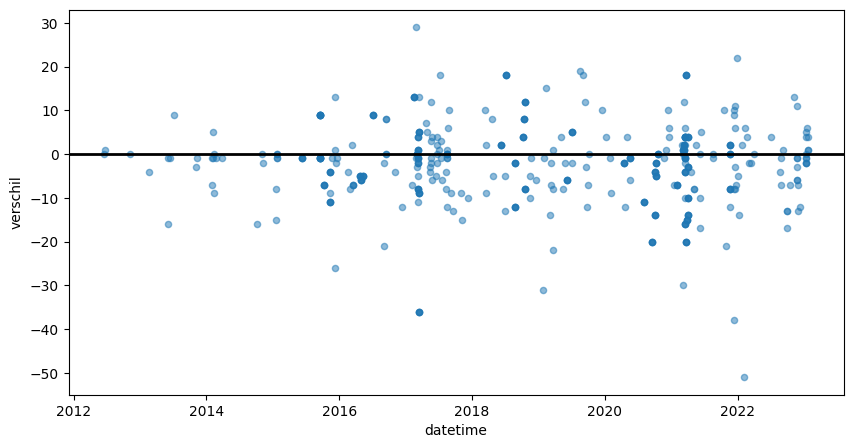

In [94]:
# Plot verschil positief negatief
plt.rcParams["figure.figsize"] = (10, 5)
data.plot.scatter(x="datetime", y="verschil", alpha=0.5)
plt.axhline(y=0, linewidth=2, color='black')

In [95]:
# Gemiddelde per maand
data_mean = data.groupby(pd.Grouper(key='datetime',freq='M')).mean().reset_index()
# Aantal artikelen per maand
data_count = data.groupby(pd.Grouper(key='datetime',freq='M')).count().reset_index()
data_count = data_count[['datetime', 'pagelink']].rename(columns={'pagelink': 'number_of_articles'})
# Samenvoegen
data_mean_count = data_mean.merge(data_count, on = 'datetime', how='left')
data_mean_count.head(3)

datetime  positive  negative  verschil  number_of_articles
0 2012-06-30      10.5      10.0       0.5                   2
1 2012-07-31       NaN       NaN       NaN                   0
2 2012-08-31       NaN       NaN       NaN                   0

<AxesSubplot:xlabel='datetime', ylabel='number_of_articles'>

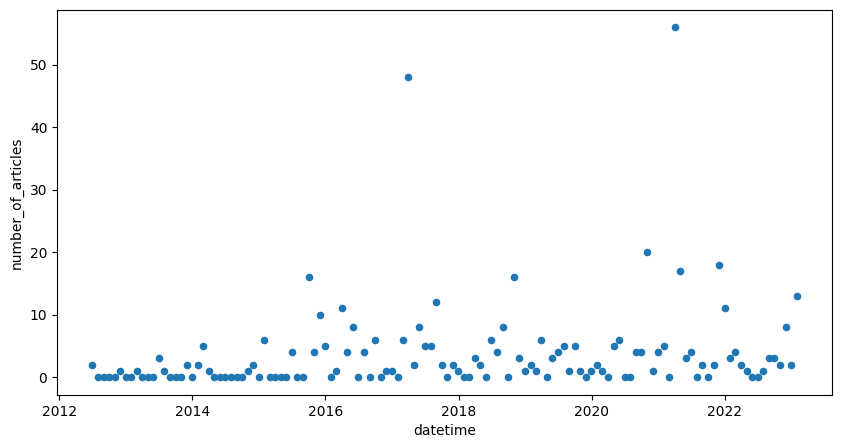

In [96]:
# Plot aantal artikelen per maand
plt.rcParams["figure.figsize"] = (10, 5)
data_mean_count.plot.scatter(x="datetime", y='number_of_articles')